## Summarization with HuggingFace | NLP Projects | Fine Tuning T5 Transformer

Summarization in Natural Language Processing (NLP) involves the automatic generation of concise and coherent summaries from longer texts or documents.

## Coding

https://huggingface.co/

In [ ]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install -U sentencepiece
!pip install -U urllib3
!pip install py7zr

In [2]:
# The CNN/DailyMail Dataset
# The CNN/DailyMail dataset consists of around 300,000 pairs of news articles and
# their corresponding summaries, composed from the bullet points that CNN and the
# DailyMail attach to their articles.
# summaries are abstractive and not extractive

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", '3.0.0', split="train[:10]")

In [4]:
print(dataset[0]['article'])
print("\nSummary:\n")
print(dataset[0]['highlights'])

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details of how

In [ ]:
from transformers import pipeline
import torch

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
summary = {}
pipe = pipeline('summarization', model = 'ubikpt/t5-small-finetuned-cnn', device=device)
output = pipe(dataset[0]['article'])
summary['t5-small'] = output[0]['summary_text']

pipe = pipeline('summarization', model = 'facebook/bart-large-cnn', device=device)
output = pipe(dataset[0]['article'])
summary['bart-large'] = output[0]['summary_text']

In [6]:
for model in summary:
    print()
    print(model)
    print(summary[model])


t5-small
Harry Potter star Daniel Radcliffe says he has no plans to fritter his cash away . The actor has filmed a TV movie about author Rudyard Kipling

bart-large
Harry Potter star Daniel Radcliffe turns 18 on Monday. He gains access to a reported £20 million ($41.1 million) fortune. Radcliffe's earnings from the first five Potter films have been held in a trust fund. Details of how he'll mark his landmark birthday are under wraps.


### Fine-Tuning Summarization Model on Custom Dataset

https://huggingface.co/datasets/samsum

In [14]:
# samsum = load_dataset("samsum")

In [ ]:
from datasets import load_dataset

samsum = load_dataset("knkarthick/dialogsum")

In [19]:
samsum['train'][0]

{'id': 'train_0',
 'dialogue': "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 'summary': "Mr. Smith'

In [20]:
dialogue_len = [len(x['dialogue'].split()) for x in samsum['train']]
summary_len = [len(x['summary'].split()) for x in samsum['train']]

array([[<Axes: title={'center': 'Dialogue Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

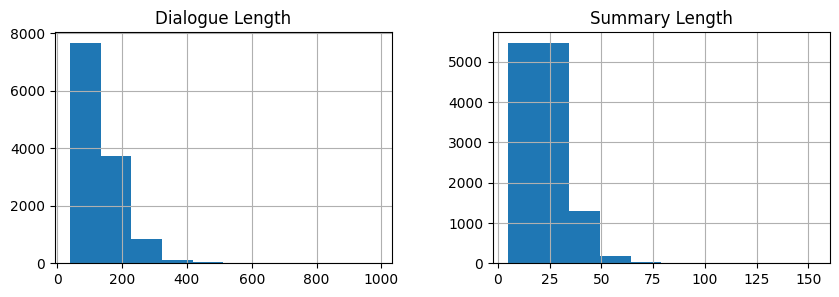

In [21]:
import pandas as pd

data = pd.DataFrame([dialogue_len, summary_len]).T
data.columns = ['Dialogue Length', 'Summary Length']

data.hist(figsize=(10,3))

## Model Loading and Tokenization

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_ckpt = 't5-small'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [23]:
samsum['train'][0]

{'id': 'train_0',
 'dialogue': "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 'summary': "Mr. Smith'

In [24]:
tokenizer(samsum['train'][0]['dialogue'], text_target=samsum['train'][0]['summary'], return_tensors='pt')

{'input_ids': tensor([[ 1713,   345, 13515,   536,  4663,    10,  2018,     6,  1363,     5,
          3931,     5,    27,    31,    51,  7582, 12833,    77,     7,     5,
          1615,    33,    25,   270,   469,    58,  1713,   345, 13515,   357,
          4663,    10,    27,   435,    34,   133,    36,     3,     9,   207,
           800,    12,   129,     3,     9,   691,    18,   413,     5,  1713,
           345, 13515,   536,  4663,    10,  2163,     6,   168,     6,    25,
            43,    29,    31,    17,   141,    80,    21,   305,   203,     5,
           148,   225,    43,    80,   334,   215,     5,  1713,   345, 13515,
           357,  4663,    10,    27,   214,     5,    27,  2320,    38,   307,
            38,   132,    19,  1327,  1786,     6,   572,   281,   217,     8,
          2472,    58,  1713,   345, 13515,   536,  4663,    10,  1548,     6,
             8,   200,   194,    12,  1792,  2261, 21154,    19,    12,   253,
            91,    81,   135,   778,  

In [25]:
def tokenize(batch):
    encoding = tokenizer(batch['dialogue'], text_target=batch['summary'], max_length=512, truncation=True, padding=True, return_tensors='pt')

    return encoding

In [ ]:
samsum_pt = samsum.map(tokenize, batched=True, batch_size=None)

In [27]:
samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1500
    })
})

## Model Training

In [28]:
from transformers import DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

args = TrainingArguments(
    output_dir="train_dir",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_strategy='epoch',
    save_strategy='epoch',
    weight_decay=0.01,
    learning_rate=2e-5,
    gradient_accumulation_steps=350
)

trainer = Trainer(model=model,
                  args=args,
                  tokenizer=tokenizer,
                  data_collator=data_collator,
                  train_dataset=samsum_pt['train'],
                  eval_dataset=samsum_pt['validation']
                  )

trainer.train()

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: WARNING Invalid choice
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss
1,No log,9.526363
2,No log,6.612730
3,No log,3.388471
4,No log,1.880823
5,No log,1.381954
6,No log,1.127720
7,No log,1.036260
8,No log,1.004338
9,No log,0.992133
10,No log,0.988248


TrainOutput(global_step=90, training_loss=3.3754652235243054, metrics={'train_runtime': 7656.37, 'train_samples_per_second': 16.274, 'train_steps_per_second': 0.012, 'total_flos': 1.68635884634112e+16, 'train_loss': 3.3754652235243054, 'epoch': 10.0})

In [29]:
trainer.save_model("t5_samsum_summarization")

## Prediction

In [30]:
from transformers import pipeline

In [31]:
pipe = pipeline('summarization', model='t5_samsum_summarization', device=device)

custom_dialogue="""
Laxmi Kant: what work you planning to give Tom?
Juli: i was hoping to send him on a business trip first.
Laxmi Kant: cool. is there any suitable work for him?
Juli: he did excellent in last quarter. i will assign new project, once he is back.
"""

output = pipe(custom_dialogue)
output

Device set to use cuda
Your max_length is set to 200, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


[{'summary_text': 'laxmi Kant: i was hoping to send him on a business trip first . i will assign new project once he is back .'}]